Using device: cpu
Training Enhanced KAN with 128 hidden dimensions and 12 knots per dimension
Training for 15 epochs with cosine annealing lr scheduler


Epoch 1: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s, loss=7.16, ce_loss=0.347, center_loss=68.1, acc=92.1, lr=0.001]


Test Loss: 0.1199, Test Accuracy: 96.44%


Epoch 2: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s, loss=5.47, ce_loss=0.115, center_loss=53.5, acc=96.6, lr=0.000996]


Test Loss: 0.0984, Test Accuracy: 96.97%


Epoch 3: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s, loss=4.87, ce_loss=0.0915, center_loss=47.8, acc=97.3, lr=0.000984]


Test Loss: 0.0907, Test Accuracy: 97.20%


Epoch 4: 100%|██████████| 469/469 [00:40<00:00, 11.64it/s, loss=4.48, ce_loss=0.0816, center_loss=44, acc=97.5, lr=0.000965]  


Test Loss: 0.0833, Test Accuracy: 97.50%


Epoch 5: 100%|██████████| 469/469 [01:38<00:00,  4.78it/s, loss=4.2, ce_loss=0.0732, center_loss=41.2, acc=97.8, lr=0.000939] 


Test Loss: 0.0811, Test Accuracy: 97.60%


Epoch 6: 100%|██████████| 469/469 [03:07<00:00,  2.50it/s, loss=4.01, ce_loss=0.0669, center_loss=39.4, acc=98, lr=0.000905]  


Test Loss: 0.0796, Test Accuracy: 97.56%


Epoch 7: 100%|██████████| 469/469 [03:07<00:00,  2.50it/s, loss=3.86, ce_loss=0.0611, center_loss=38, acc=98.2, lr=0.000866]  


Test Loss: 0.0788, Test Accuracy: 97.72%


Epoch 8: 100%|██████████| 469/469 [02:52<00:00,  2.72it/s, loss=3.78, ce_loss=0.0574, center_loss=37.2, acc=98.3, lr=0.000821]


Test Loss: 0.0789, Test Accuracy: 97.74%


Epoch 9: 100%|██████████| 469/469 [02:39<00:00,  2.94it/s, loss=3.72, ce_loss=0.0536, center_loss=36.6, acc=98.4, lr=0.00077]


Test Loss: 0.0745, Test Accuracy: 97.93%


Epoch 10: 100%|██████████| 469/469 [02:14<00:00,  3.48it/s, loss=3.67, ce_loss=0.0496, center_loss=36.2, acc=98.6, lr=0.000716]


Test Loss: 0.0753, Test Accuracy: 97.87%


Epoch 11: 100%|██████████| 469/469 [02:59<00:00,  2.62it/s, loss=3.63, ce_loss=0.0458, center_loss=35.9, acc=98.6, lr=0.000658]


Test Loss: 0.0766, Test Accuracy: 97.78%


Epoch 12: 100%|██████████| 469/469 [03:05<00:00,  2.53it/s, loss=3.59, ce_loss=0.0432, center_loss=35.5, acc=98.7, lr=0.000598]


Test Loss: 0.0772, Test Accuracy: 97.78%


Epoch 13: 100%|██████████| 469/469 [11:50<00:00,  1.52s/it, loss=3.56, ce_loss=0.04, center_loss=35.2, acc=98.8, lr=0.000536]     


Test Loss: 0.0758, Test Accuracy: 97.94%


Epoch 14: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s, loss=3.55, ce_loss=0.0392, center_loss=35.1, acc=98.8, lr=0.000474]


Test Loss: 0.0748, Test Accuracy: 97.92%


Epoch 15: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s, loss=3.53, ce_loss=0.0356, center_loss=35, acc=98.9, lr=0.000412]  


Test Loss: 0.0790, Test Accuracy: 97.86%
Training completed in 2348.46 seconds (39.14 minutes)
Final test accuracy: 97.86%


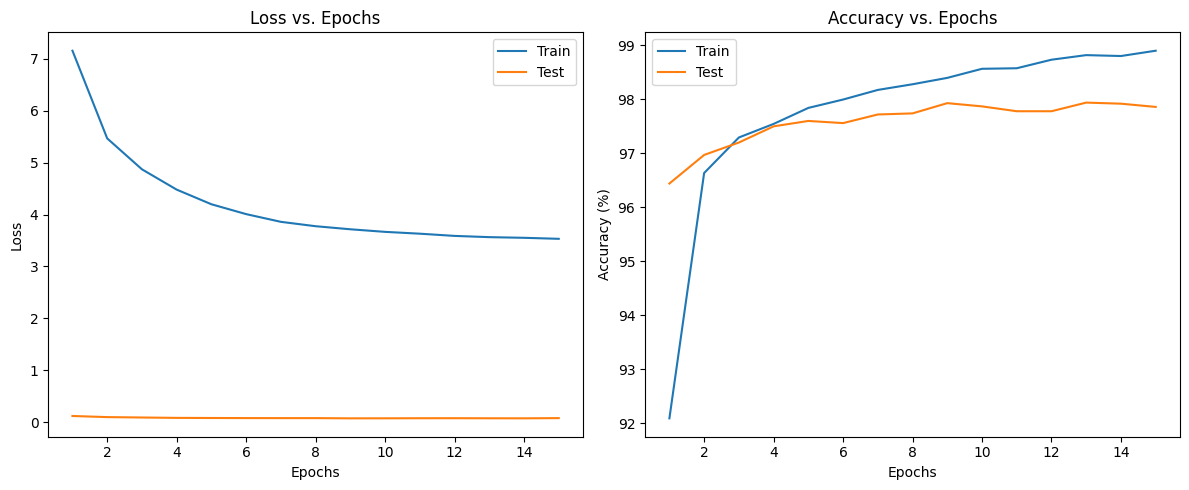

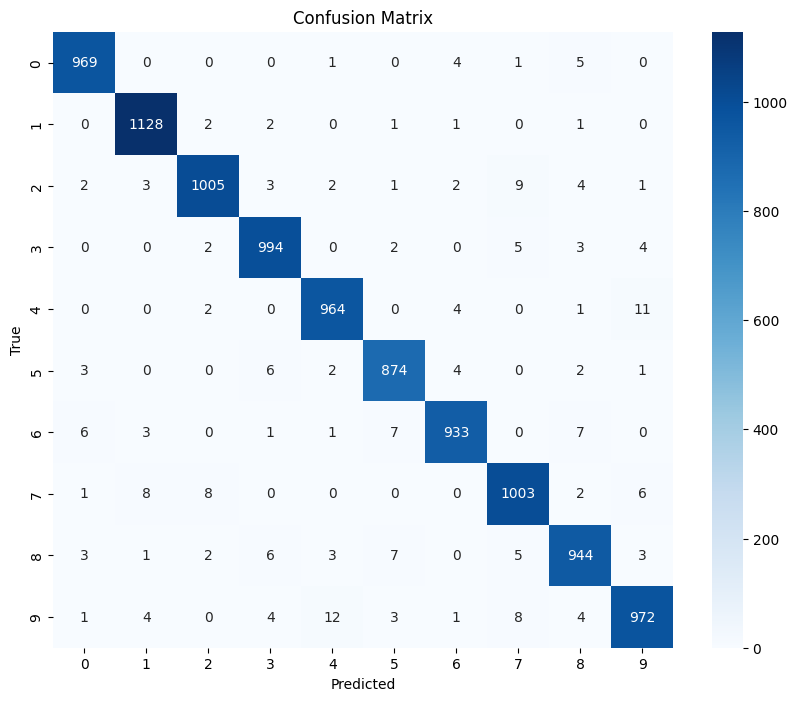

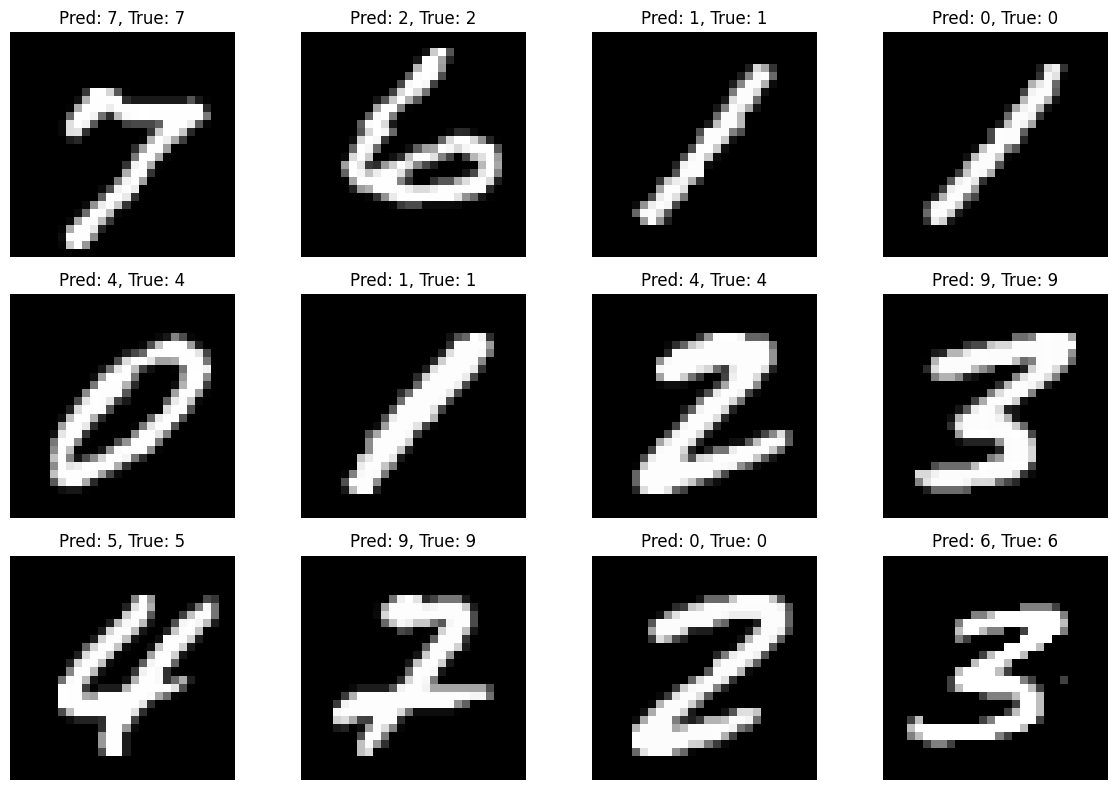

Model saved to 'enhanced_kan_mnist.pth'


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

# Set random seeds for reproducibility
torch.manual_seed(100)
np.random.seed(100)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define improved basis functions for KAN
class EnhancedBSplineBasis(nn.Module):
    def __init__(self, num_knots=10, degree=3):
        super(EnhancedBSplineBasis, self).__init__()
        self.num_knots = num_knots
        self.degree = degree
        # Initialize knots with better spacing - covers the normalized data range
        self.knots = nn.Parameter(torch.linspace(-2.5, 2.5, num_knots))
        # Learnable width parameters for each knot
        self.widths = nn.Parameter(torch.ones(num_knots) * 0.5)
        
    def forward(self, x):
        # Compute distances from knots with learnable widths
        x_expanded = x.unsqueeze(-1)  # [batch_size, 1, 1] for MNIST pixels
        knots_expanded = self.knots.unsqueeze(0)  # [1, num_knots]
        widths_expanded = torch.abs(self.widths).unsqueeze(0)  # Ensure widths are positive
        
        # RBF with learnable widths
        distances = torch.abs(x_expanded - knots_expanded)
        weights = torch.exp(-(distances**2) / (widths_expanded**2 + 1e-6))
        
        # Normalize weights
        weights = weights / (torch.sum(weights, dim=-1, keepdim=True) + 1e-8)
        return weights

# Enhanced Kolmogorov-Arnold Network with residual connections
class EnhancedKAN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_layers=2, num_knots=10):
        super(EnhancedKAN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_knots = num_knots
        
        # Projection layer with batch normalization
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2)
        )
        
        # KAN layers with enhanced basis functions
        self.basis_functions = nn.ModuleList([
            EnhancedBSplineBasis(num_knots=num_knots) for _ in range(hidden_dim)
        ])
        
        # Middle layer with residual connection
        self.middle_layer = nn.Sequential(
            nn.Linear(hidden_dim * num_knots, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Flatten the input
        x = x.view(batch_size, -1)
        
        # Project to lower dimension
        z = self.projection(x)
        
        # Apply basis functions to each dimension
        basis_outputs = []
        for i in range(self.hidden_dim):
            basis_output = self.basis_functions[i](z[:, i])
            basis_outputs.append(basis_output)
        
        # Concatenate all basis function outputs
        combined = torch.cat(basis_outputs, dim=1)
        
        # Apply middle layer
        middle_output = self.middle_layer(combined)
        
        # Apply output layer
        output = self.output_layer(middle_output)
        
        return output

# Initialize model and optimizer
input_dim = 28 * 28  # MNIST image size
output_dim = 10      # 10 classes (digits 0-9)
hidden_dim = 128
num_knots = 12

model = EnhancedKAN(input_dim, output_dim, hidden_dim=hidden_dim, num_layers=2, num_knots=num_knots)
model = model.to(device)

# Define enhanced loss function (combining cross-entropy with center loss)
class EnhancedLoss(nn.Module):
    def __init__(self, num_classes=10, feat_dim=128, device=device):
        super(EnhancedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))
        self.lambda_c = 0.1  # Weight for center loss
        
    def forward(self, feat, scores, targets):
        batch_size = feat.size(0)
        ce_loss = self.ce_loss(scores, targets)
        
        # Compute center loss
        centers_batch = self.centers[targets]
        center_loss = torch.sum((feat - centers_batch) ** 2) / batch_size
        
        # Combined loss
        loss = ce_loss + self.lambda_c * center_loss
        return loss, ce_loss, center_loss

# Create optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

# Define criterion (using feature output before softmax for center loss)
criterion = EnhancedLoss(num_classes=10, feat_dim=hidden_dim, device=device)

# Training function with feature output
def train(model, train_loader, optimizer, criterion, scheduler, epoch):
    model.train()
    train_loss = 0
    train_ce_loss = 0
    train_center_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Get features before final layer
        batch_size = data.size(0)
        x = data.view(batch_size, -1)
        z = model.projection(x)
        
        # Apply basis functions
        basis_outputs = []
        for i in range(model.hidden_dim):
            basis_output = model.basis_functions[i](z[:, i])
            basis_outputs.append(basis_output)
        
        combined = torch.cat(basis_outputs, dim=1)
        features = model.middle_layer(combined)
        scores = model.output_layer(features)
        
        # Compute loss with features
        loss, ce_loss, center_loss = criterion(features, scores, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_ce_loss += ce_loss.item()
        train_center_loss += center_loss.item()
        
        _, predicted = scores.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({
            'loss': train_loss/(batch_idx+1), 
            'ce_loss': train_ce_loss/(batch_idx+1),
            'center_loss': train_center_loss/(batch_idx+1),
            'acc': 100.*correct/total,
            'lr': scheduler.get_last_lr()[0]
        })
    
    # Step the scheduler at the end of each epoch
    scheduler.step()
    
    return train_loss/len(train_loader), 100.*correct/total

# Testing function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    ce_criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += ce_criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Training loop
epochs = 15
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Training Enhanced KAN with {hidden_dim} hidden dimensions and {num_knots} knots per dimension")
print(f"Training for {epochs} epochs with cosine annealing lr scheduler")

start_time = time.time()

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, epoch)
    test_loss, test_acc = test(model, test_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Final test accuracy: {test_accs[-1]:.2f}%")

# Plot results
def plot_results(train_losses, test_losses, train_accs, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(range(1, epochs + 1), train_losses, label='Train')
    ax1.plot(range(1, epochs + 1), test_losses, label='Test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.legend()
    
    ax2.plot(range(1, epochs + 1), train_accs, label='Train')
    ax2.plot(range(1, epochs + 1), test_accs, label='Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('kan_performance.png')
    plt.show()

# Visualize model performance
plot_results(train_losses, test_losses, train_accs, test_accs)

# Visualize some predictions with confusion matrix
def visualize_predictions(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    # Get some test examples
    data, targets = next(iter(test_loader))
    data, targets = data.to(device), targets.to(device)
    outputs = model(data)
    _, predictions = outputs.max(1)
    
    # Get predictions for confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = output.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('kan_confusion_matrix.png')
    plt.show()
    
    # Plot example predictions
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(data[i][0].cpu(), cmap='gray')
        plt.title(f'Pred: {predictions[i].item()}, True: {targets[i].item()}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('kan_examples.png')
    plt.show()

visualize_predictions(model, test_loader)

# Save model
torch.save(model.state_dict(), 'enhanced_kan_mnist.pth')
print("Model saved to 'enhanced_kan_mnist.pth'")

## Quantum Version

Running on: cpu


100%|██████████| 9.91M/9.91M [00:06<00:00, 1.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 890kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 334kB/s]


Starting hybrid training with 4 qubits


Training Epoch 1: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s, loss=2.31, acc=11] 


Evaluation - Loss: 2.2601, Accuracy: 15.00%


Training Epoch 2: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s, loss=2.3, acc=11]  


Evaluation - Loss: 2.2621, Accuracy: 13.75%


Training Epoch 3: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2626, Accuracy: 13.75%


Training Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2642, Accuracy: 13.75%


Training Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2649, Accuracy: 13.75%


Training Epoch 6: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2667, Accuracy: 13.75%


Training Epoch 7: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2660, Accuracy: 13.75%


Training Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2662, Accuracy: 13.75%


Training Epoch 9: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2646, Accuracy: 13.75%


Training Epoch 10: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2634, Accuracy: 13.75%


Training Epoch 11: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, loss=2.29, acc=13] 


Evaluation - Loss: 2.2631, Accuracy: 13.75%


Training Epoch 12: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s, loss=2.28, acc=13] 


Evaluation - Loss: 2.2626, Accuracy: 13.75%


Training Epoch 13: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s, loss=2.28, acc=13] 


Evaluation - Loss: 2.2629, Accuracy: 13.75%


Training Epoch 14: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s, loss=2.28, acc=13] 


Evaluation - Loss: 2.2622, Accuracy: 13.75%


Training Epoch 15: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s, loss=2.28, acc=13.2]


Evaluation - Loss: 2.2562, Accuracy: 13.75%
Training completed in 6.37 minutes
Final accuracy: 13.75%


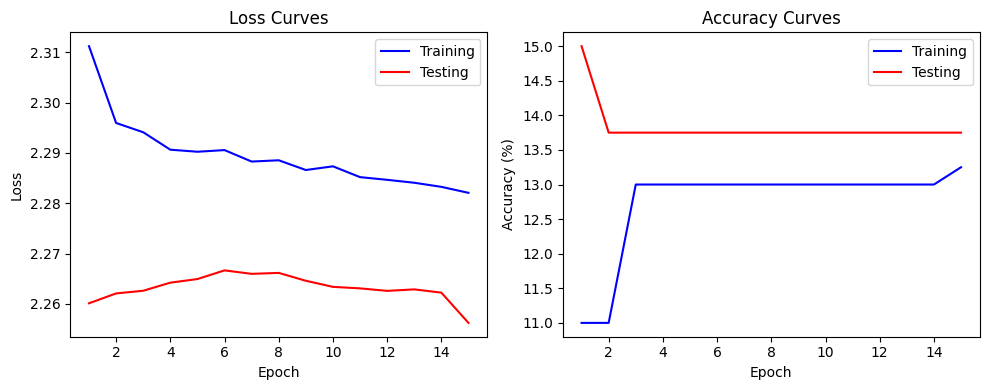

Model saved as 'hybrid_model.pth'


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm import tqdm
import time

# Set seeds for consistent results
torch.manual_seed(123)
np.random.seed(123)

# Device configuration
computing_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {computing_device}")

# Quantum circuit parameters
qubit_count = 4
layer_count = 2

# Quantum device setup
quantum_sim = qml.device("default.qubit", wires=qubit_count)

# Quantum circuit definition
@qml.qnode(quantum_sim, interface="torch")
def quantum_processor(data_input, parameters):
    # Input encoding
    for q in range(qubit_count):
        qml.RX(data_input[q], wires=q)
    
    # Parameterized layers
    for layer in range(layer_count):
        # Quantum gates
        for q in range(qubit_count):
            qml.RZ(parameters[layer, q, 0], wires=q)
            qml.RY(parameters[layer, q, 1], wires=q)
            qml.RX(parameters[layer, q, 2], wires=q)
        
        # Entangling operations
        for q in range(qubit_count-1):
            qml.CZ(wires=[q, q+1])
        qml.CZ(wires=[qubit_count-1, 0])
    
    return [qml.expval(qml.PauliY(q)) for q in range(qubit_count)]

# Quantum feature transformer
class QuantumTransformer(nn.Module):
    def __init__(self, qubits=qubit_count, layers=layer_count):
        super().__init__()
        self.qubits = qubits
        self.layers = layers
        self.params = nn.Parameter(torch.randn(layers, qubits, 3) * 0.05)
    
    def forward(self, input_data):
        batch_size = input_data.shape[0]
        results = torch.zeros(batch_size, self.qubits, device=input_data.device)
        
        for b in range(batch_size):
            sample = input_data[b, :self.qubits]
            quantum_output = torch.tensor(quantum_processor(sample, self.params))
            results[b] = quantum_output
            
        return results

# Hybrid quantum-classical network
class HybridNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=8):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Pre-processing layers
        self.pre_processor = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, hidden_size),
            nn.Sigmoid()
        )
        
        # Quantum component
        self.quantum_core = QuantumTransformer()
        
        # Post-processing layers
        self.post_processor = nn.Sequential(
            nn.Linear(qubit_count, 12),
            nn.LeakyReLU(0.1),
            nn.Linear(12, output_size)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        features = self.pre_processor(x)
        quantum_features = self.quantum_core(features[:, :qubit_count])
        output = self.post_processor(quantum_features)
        
        return output

# Data preparation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.31,))
])

mnist_train = datasets.MNIST('./mnist_data', train=True, download=True, transform=data_transform)
mnist_test = datasets.MNIST('./mnist_data', train=False, transform=data_transform)

train_size = 400
test_size = 80

train_indices = list(range(train_size))
test_indices = list(range(test_size))

train_data = Subset(mnist_train, train_indices)
test_data = Subset(mnist_test, test_indices)

batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Model setup
model = HybridNet(784, 10, hidden_size=8).to(computing_device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_model(model, loader, opt, loss_func, epoch):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    
    progress = tqdm(loader, desc=f'Training Epoch {epoch}')
    for batch, (images, labels) in enumerate(progress):
        images, labels = images.to(computing_device), labels.to(computing_device)
        opt.zero_grad()
        
        predictions = model(images)
        loss = loss_func(predictions, labels)
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        pred_classes = predictions.argmax(dim=1)
        correct_preds += (pred_classes == labels).sum().item()
        total_samples += labels.size(0)
        
        progress.set_postfix({
            'loss': total_loss/(batch+1),
            'acc': 100.*correct_preds/total_samples
        })
    
    return total_loss/len(loader), 100.*correct_preds/total_samples

# Evaluation function
def evaluate_model(model, loader, loss_func):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(computing_device), labels.to(computing_device)
            predictions = model(images)
            
            total_loss += loss_func(predictions, labels).item()
            pred_classes = predictions.argmax(dim=1)
            total_samples += labels.size(0)
            correct_preds += (pred_classes == labels).sum().item()
    
    avg_loss = total_loss/len(loader)
    accuracy = 100.*correct_preds/total_samples
    print(f'Evaluation - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Training execution
epochs = 15
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print(f"Starting hybrid training with {qubit_count} qubits")
start_time = time.time()

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_model(model, train_loader, optimizer, loss_fn, ep)
    ts_loss, ts_acc = evaluate_model(model, test_loader, loss_fn)
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    test_losses.append(ts_loss)
    test_accs.append(ts_acc)

duration = time.time() - start_time
print(f"Training completed in {duration/60:.2f} minutes")
print(f"Final accuracy: {test_accs[-1]:.2f}%")

# Visualization functions
def plot_performance():
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training')
    plt.plot(range(1, epochs+1), test_losses, 'r-', label='Testing')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1, epochs+1), train_accs, 'b-', label='Training')
    plt.plot(range(1, epochs+1), test_accs, 'r-', label='Testing')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('hybrid_performance.png')
    plt.show()

plot_performance()

# Save model
torch.save(model.state_dict(), 'hybrid_model.pth')
print("Model saved as 'hybrid_model.pth'")